In [1]:
import pandas as pd
import numpy as np
import importlib
import time

In [17]:
import matplotlib.pyplot as plt

In [2]:
import disall

In [3]:
from icet import ClusterSpace, StructureContainer, ClusterExpansion
from trainstation import CrossValidationEstimator

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
importlib.reload(disall)

<module 'disall' (<_frozen_importlib_external._NamespaceLoader object at 0x14569b71ad10>)>

In [22]:
from disall.ce_parsing import parse_to_ce, filter_strain
from disall.enumerate import structures_pool
from disall.quick_plot import parity_plot, set_font, plot_ce

In [7]:
df = pd.read_pickle('data_protocol4.pkl', )

In [8]:
df = df[~df['chgnet'].isnull()]
df

,init_structure,size,chgnet
0,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",1,"((Atom('Al', [0.0, 0.0, 0.0], index=0)), -3.30..."
1,"(Atom('Co', [0.0, 0.0, 0.0], index=0))",1,"((Atom('Co', [0.0, 0.0, 0.0], index=0)), -6.93..."
2,"(Atom('Cr', [0.0, 0.0, 0.0], index=0))",1,"((Atom('Cr', [0.0, 0.0, 0.0], index=0)), -9.11..."
3,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",1,"((Atom('Cu', [0.0, 0.0, 0.0], index=0)), -3.97..."
4,"(Atom('Fe', [0.0, 0.0, 0.0], index=0))",1,"((Atom('Fe', [0.0, 0.0, 0.0], index=0)), -8.18..."
...,...,...,...
24995,"(Atom('Co', [0.0, 0.0, 0.0], index=0), Atom('F...",6,"((Atom('Co', [-5.6944767655819984e-08, 6.82886..."
24996,"(Atom('Co', [0.0, 0.0, 0.0], index=0), Atom('F...",6,"((Atom('Co', [-8.037595437119736e-08, -1.77951..."
24997,"(Atom('Co', [0.0, 0.0, 0.0], index=0), Atom('F...",6,"((Atom('Co', [-2.4783974815253773e-07, -1.2455..."
24998,"(Atom('Co', [0.0, 0.0, 0.0], index=0), Atom('F...",6,"((Atom('Co', [-2.8099467769636366e-08, -3.6403..."


In [9]:
relax_chgnet_df, prim, constant_a0, elements = parse_to_ce(df, 'chgnet')
work_df = filter_strain(relax_chgnet_df, 0.05)

In [10]:
cs_fcc = ClusterSpace(structure=prim, cutoffs=[constant_a0*2.5, constant_a0*1.3, constant_a0*0.72],
                  chemical_symbols=[elements])
sc_fcc = StructureContainer(cs_fcc)

In [12]:
ti = time.time()
work_df.apply(lambda x: sc_fcc.add_structure(x['init_structure'],
    properties={'mix_energy': x['energy_reference'],}
                                               ), axis=1)
print('{}s'.format(time.time() - ti))

339.2086479663849s


In [13]:
opt_meg = CrossValidationEstimator(sc_fcc.get_fit_data(key='mix_energy'),
                                   n_splits=10, fit_method='ardr')

In [14]:
# ardr
opt_meg.validate()
print(opt_meg.R2_validation)
print(opt_meg.rmse_validation)
print(opt_meg.n_nonzero_parameters_splits)
print(opt_meg.rmse_validation_splits)

/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 1.520829953512933e+17
  warnings.warn(f'Warning: Condition number is large, {cond}')
/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 1.622603810024093e+17
  warnings.warn(f'Warning: Condition number is large, {cond}')
/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 1.2432395806636662e+17
  warnings.warn(f'Warning: Condition number is large, {cond}')
/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 1.3529274737295557e+17
  warnings.wa

0.9913286092585738
0.012636673047991615
[111 109 112 105 104 113 117 106 113 114]
[0.01322488 0.01243038 0.01222181 0.01330928 0.01253073 0.01274044
 0.01264823 0.01266398 0.0124311  0.01216589]


In [18]:
set_font(plt)

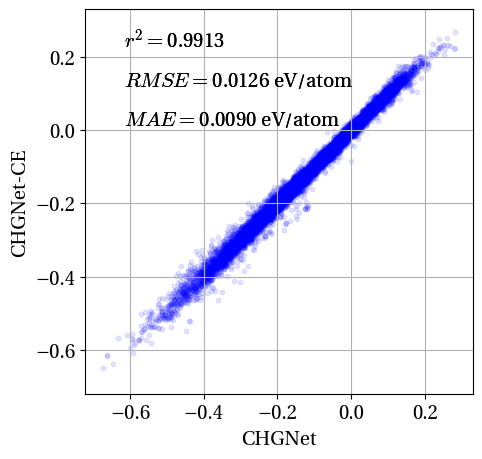

In [19]:
parity_plot([[opt_meg.scatter_data_validation.target, opt_meg.scatter_data_validation.predicted]],alpha=0.1, s=10,
            unit= ' eV/atom', xlabel='CHGNet', ylabel='CHGNet-CE')

In [20]:
opt_meg.train()
ce_ = ClusterExpansion(cs_fcc, opt_meg.parameters)

/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 1.429216784812605e+17
  warnings.warn(f'Warning: Condition number is large, {cond}')


In [24]:
ce_.write('ce_0131.pkl')

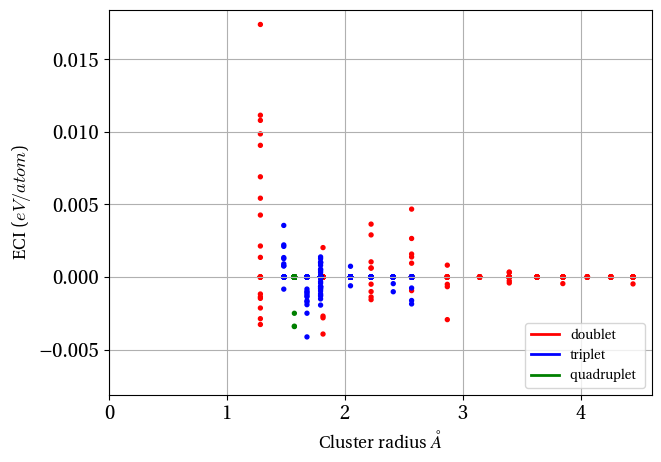

In [23]:
df_ce = ce_.to_dataframe()
plot_ce(df_ce)

# only 4 elements

In [49]:
relax_chgnet_df, prim, constant_a0, elements = parse_to_ce(df, 'chgnet')
work_df = filter_strain(relax_chgnet_df, 0.05)

four_df = work_df[(work_df[['Fe', 'Mn', 'Ni', 'V']] <= 1E-8).all(axis=1)]
elements = elements[:4]

In [50]:
elements

['Al', 'Co', 'Cr', 'Cu']

In [51]:
cs_fcc = ClusterSpace(structure=prim, cutoffs=[constant_a0*2.5, constant_a0*1.3, constant_a0*0.72],
                  chemical_symbols=[elements])
sc_fcc = StructureContainer(cs_fcc)

In [52]:
ti = time.time()
four_df.apply(lambda x: sc_fcc.add_structure(x['init_structure'],
    properties={'mix_energy': x['energy_reference'],}
                                               ), axis=1)
print('{}s'.format(time.time() - ti))

3.0820863246917725s


In [53]:
opt_meg = CrossValidationEstimator(sc_fcc.get_fit_data(key='mix_energy'),
                                   n_splits=10, fit_method='ardr')

In [54]:
# ardr
opt_meg.validate()
print(opt_meg.R2_validation)
print(opt_meg.rmse_validation)
print(opt_meg.n_nonzero_parameters_splits)
print(opt_meg.rmse_validation_splits)

/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 6.294287533511462e+16
  warnings.warn(f'Warning: Condition number is large, {cond}')
/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 6.823330931207552e+16
  warnings.warn(f'Warning: Condition number is large, {cond}')
/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 5.203552158787106e+16
  warnings.warn(f'Warning: Condition number is large, {cond}')
/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 5.35239527215237e+16
  warnings.warn(

0.9933317037676577
0.012010570102351206
[70 69 71 71 67 66 64 70 62 72]
[0.0114647  0.01273573 0.01185575 0.01128491 0.01104877 0.01154945
 0.01236861 0.01044618 0.01401602 0.01333558]


/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 4.686897226625418e+16
  warnings.warn(f'Warning: Condition number is large, {cond}')
/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 7.302479179730546e+16
  warnings.warn(f'Warning: Condition number is large, {cond}')


In [55]:
set_font(plt)

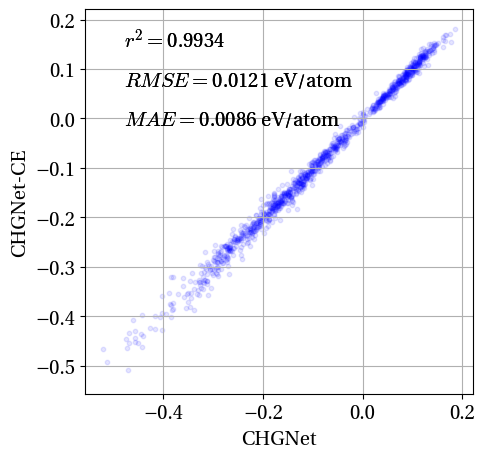

In [56]:
parity_plot([[opt_meg.scatter_data_validation.target, opt_meg.scatter_data_validation.predicted]],alpha=0.1, s=10,
            unit= ' eV/atom', xlabel='CHGNet', ylabel='CHGNet-CE')

In [57]:
opt_meg.train()
ce_ = ClusterExpansion(cs_fcc, opt_meg.parameters)

/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 6.330888832234142e+16
  warnings.warn(f'Warning: Condition number is large, {cond}')


In [58]:
ce_.write('ce_four.pkl')